# Using the Titanic DataSet as a Case Study to compare Active and Passive Learning

On April 15, 1912 during her maiden voyage, the "unsinkable" RMS Titanic sank 1 hour after colliding wiht an iceberge. It is one of the most infamous maritime disasters in history, and has inspired several cultural references including the Award-winning James Cameron movie of the same name. 

1502 out of 2224 passengers died in the sinking. Some people were more likely to survive than others. This dataset was first created by Kaggle to answer the question "What sort of people were more likely to survive the sinking?" It is a popular ML challenge, and highly recommended to first-time challengers. 

The purpose of this experiment is to create a predictive model using two strategies: Active Learning and Passive Learning, and compare the differences, pros and cons of each process, as well as their evaluation metrics.

In [1]:
# Load the Data into variable df
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/titanic_dataset.csv')
display(df)
display(df.head(3))
display(df.info())

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

**Observations**:
* 12 columns, 891 records.
* Missing data in cabon and Embarked and Age. Can we infer the missing data or will we have to delete these information?

## Data Exploration

For the purposes of this, we will keep the data exploration simple and restricted to these questions:

1. Can we fill the missing values for Cabins, Embarked and Age?
2. Are the Cabin numbers significant i.e. correlated to class?
3. Can we find any trends in the missing Age feature wrt the other features
4. Is there any correlation between a person's family (last name) and their chances of survival?

**Question**: Are certain classes more likely to have missing records than others?

In [3]:
missing_cols = ['Age', 'Cabin', 'Embarked']
filter_survived = df['Survived'] == 1

for col in missing_cols:
    filter = df[col].isna()
    print(f'Fraction of missing {col} records per Pclass')
    display(df[filter]['Pclass'].value_counts() / df['Pclass'].value_counts().sort_values())


Fraction of missing Age records per Pclass


1    0.138889
2    0.059783
3    0.276986
Name: Pclass, dtype: float64

Fraction of missing Cabin records per Pclass


1    0.185185
2    0.913043
3    0.975560
Name: Pclass, dtype: float64

Fraction of missing Embarked records per Pclass


1    0.009259
2         NaN
3         NaN
Name: Pclass, dtype: float64

**Question**: What is the survival rate for missing records?

In [4]:
for col in ['Age', 'Cabin']:
    null_frac = df[filter_survived][col].isna().sum()/df[col].isna().sum()
    notnull_frac = df[filter_survived][col].notna().sum()/df[col].notna().sum()
    print (f"Survival of missing {col} records is {null_frac}")
    print (f"Survival of not-missing {col} records is {notnull_frac}")
    
    

Survival of missing Age records is 0.2937853107344633
Survival of not-missing Age records is 0.4061624649859944
Survival of missing Cabin records is 0.29985443959243085
Survival of not-missing Cabin records is 0.6666666666666666


**Observations**: 
`Pclass == 1` passesngers are less likely to have 'Unknown' cabin numbers. 

`Pclass == 1` passengers are the only ones with missing Embarked records

`Pclass == 3` are most likely to have missing Age records, followed by 1 and 2. Strategy would be to fill missing Age values by median/mean of class.

The `Cabin` has a significant correlation with survival rate.

In [5]:
# exploring Embarked further...
filter = df['Embarked'].isna()
display(df[filter])
# sorting the records by ticket number to see where these particular values fall 
df.sort_values('Ticket')[35:45]

PassengerId  Survived  Pclass                                       Name  \
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex   Age  SibSp  Parch  Ticket  Fare Cabin Embarked  
61   female  38.0      0      0  113572  80.0   B28      NaN  
829  female  62.0      0      0  113572  80.0   B28      NaN

PassengerId  Survived  Pclass                                       Name  \
356          357         1       1                Bowerman, Miss. Elsie Edith   
54            55         0       1             Ostby, Mr. Engelhart Cornelius   
351          352         0       1     Williams-Lambert, Mr. Fletcher Fellows   
252          253         0       1                  Stead, Mr. William Thomas   
61            62         1       1                        Icard, Miss. Amelie   
829          830         1       1  Stone, Mrs. George Nelson (Martha Evelyn)   
435          436         1       1                  Carter, Miss. Lucile Polk   
390          391         1       1                 Carter, Mr. William Ernest   
802          803         1       1        Carter, Master. William Thornton II   
763          764         1       1  Carter, Mrs. William Ernest (Lucile Polk)   

        Sex   Age  SibSp  Parch  Ticket      Fare    Cabin Embarked  
356  female  22.0      0      1  113505   55.0000      E33        S  
54     male  65.0      0      1  113509   61.9792      B30        C  
351    male   NaN      0      0  113510   35.0000     C128        S  
252    male  62.0      0      0  113514   26.5500      C87        S  
61   female  38.0      0      0  113572   80.0000      B28      NaN  
829  female  62.0      0      0  113572   80.0000      B28      NaN  
435  female  14.0      1      2  113760  120.0000  B96 B98        S  
390    male  36.0      1      2  113760  120.0000  B96 B98        S  
802    male  11.0      1      2  113760  120.0000  B96 B98        S  
763  female  36.0      1      2  113760  120.0000  B96 B98        S

**Observation**: Strong likelihood, that based on ticket number these passengers embarked at `S`.

In [6]:
# df = pd.read_csv('titanic_dataset.csv')
# df['Survived'] = df['Survived'].apply(lambda x: 'No' if x==0 else 'Yes')
# display(df['Survived'].unique())
# pd.crosstab(df['Pclass'], 
#             df['Survived'],
#             normalize='index').plot.bar(stacked=True, color={'No':"maroon", 'Yes':"forestgreen"})
# plt.xlabel('Pclass (passenger class)')
# plt.title('Survival distribution')
# plt.show()

<Figure size 300x300 with 0 Axes>

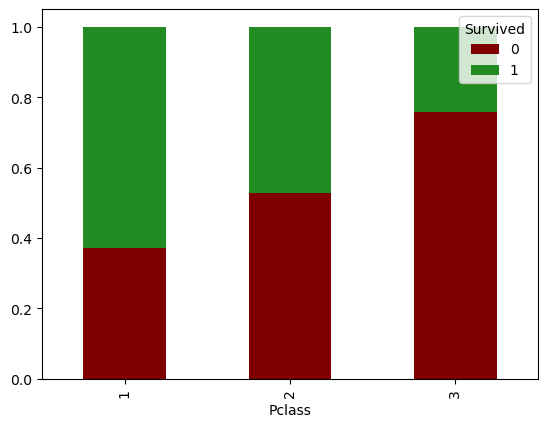

<Figure size 300x300 with 0 Axes>

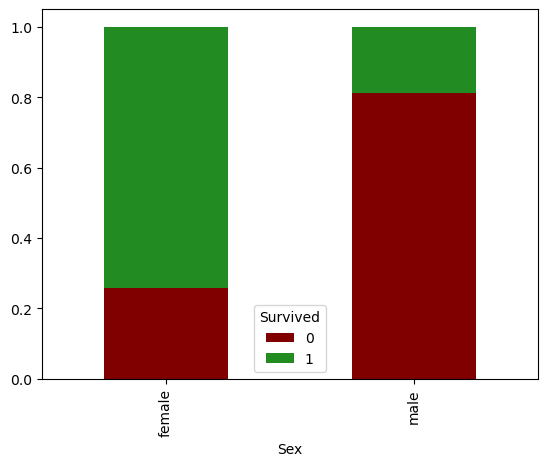

<Figure size 300x300 with 0 Axes>

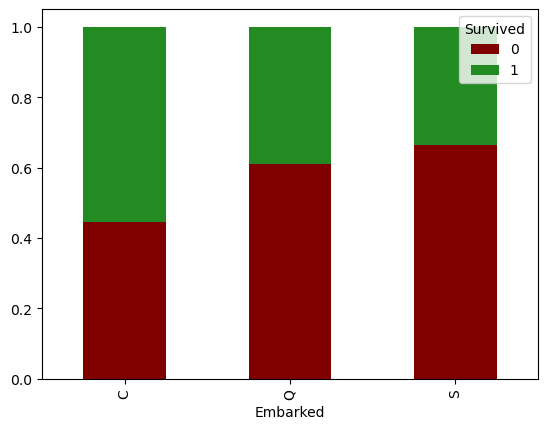

In [7]:
for cat in ['Pclass', 'Sex', 'Embarked']:
    fit = plt.figure(figsize=(3,3))
    pd.crosstab(df[cat], 
            df['Survived'],
            normalize='index').plot.bar(stacked=True, color={0:"maroon", 1:"forestgreen"})
    plt.show()

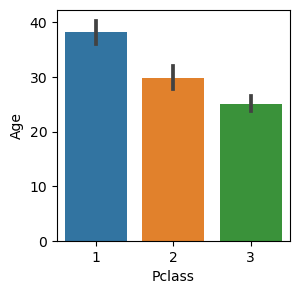

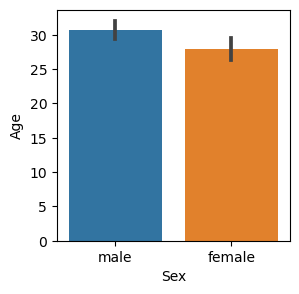

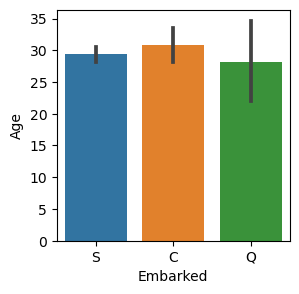

In [8]:
for cat in ['Pclass', 'Sex', 'Embarked']:
    fig = plt.figure(figsize=(3,3))
    sns.barplot(data=df, x=cat, y='Age')
    plt.show()

```python
from scipy.stats import f_oneway
   
for col in ['Pclass', 'Sex', 'Embarked']:    
    catgroup = df.groupby(col)['Age'].apply(list)
    p = f_oneway(*catgroup)[1]
    display(p)
    print (f"Age and {col} are",
          "correlated." if p<0.05 else "not correlated.")
```


In [9]:
# Last Names and chances of Survival

df['LastName'] = df['Name'].apply(lambda x: x.split(",")[0])
contingency = pd.crosstab(df['LastName'], df['Survived'])
from scipy import stats
stat, p, dof, expected = stats.chi2_contingency(contingency)
print('%.3f' % p)
print ("We", 
       "reject" if p < 0.05 else "accept",
       "the Hypothesis that Last Name and Survial rate are independent")

0.031
We reject the Hypothesis that Last Name and Survial rate are independent


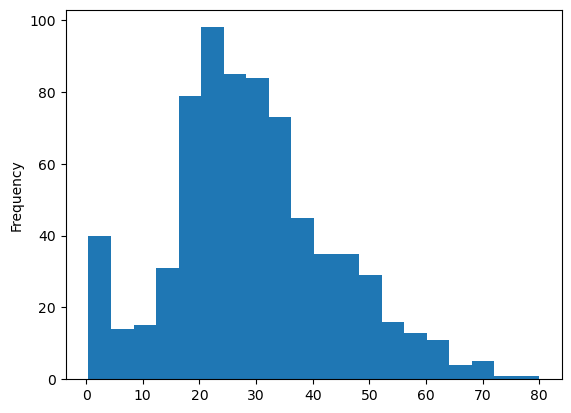

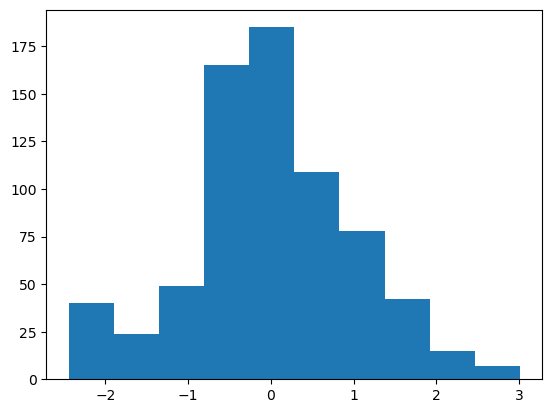

In [10]:
Age = df['Age']
Age.plot(kind='hist', bins=20)
plt.show()
from sklearn.preprocessing import PowerTransformer

bc = PowerTransformer(method="box-cox")
X_trans_bc = bc.fit(Age.values.reshape(-1,1)).transform(Age.values.reshape(-1,1))
plt.hist((X_trans_bc))
plt.show()


## Features Engineering


There are many more ways to explore this data and consequently develop informative Features. However for the purpose of this analysis which is more related to Active Learning, we will keep our strategy simple:

1. Disregard information about Tickets and Fare
2. Reduce Cabin to "Known" and "Unknown" due to the correlation between the rate of survival of Cabin passengers
3. Fill the missing information about 'Embarked' with 'S', based on the ticket pattern and most commonly embarked port.
4. Reduce 'SibSp' and 'Parch' which are all indications of travelling with family/companions to With_Family
5. Use the average value for Ages according to Sex and Pclass to fill the missing Ages.

In [11]:
df_old = df.copy() # back up for the dataset

In [12]:
df = df.drop(columns=['PassengerId', 'Ticket', 'Fare'])
df['Cabin_Info'] = df['Cabin'].apply(lambda x: 1 if x else 0)
df['Embarked'] = df['Embarked'].fillna('S')
df['Family'] = None
for idx in df.index:
    df.loc[idx, 'Family'] = 1 if (df.loc[idx, 'SibSp'] > 0 or df.loc[idx, 'Parch'] > 0) else 0
df = df.drop(columns=['SibSp', 'Parch', 'Cabin'])  

In [13]:
df.groupby(['Pclass', 'Sex'])['Age'].mean()

Pclass  Sex   
1       female    34.611765
        male      41.281386
2       female    28.722973
        male      30.740707
3       female    21.750000
        male      26.507589
Name: Age, dtype: float64

In [14]:
age_by_sex_class = df.groupby(['Pclass', 'Sex'])['Age'].mean()
age_by_sex_class
for idx in df[df['Age'].isna()].index:
    mean_age = age_by_sex_class[age_by_sex_class.index == tuple([df.loc[idx,'Pclass'], df.loc[idx,'Sex']])].values[0]
    df.loc[idx,'Age'] = mean_age

In [15]:
df

Survived  Pclass                                               Name  \
0           0       3                            Braund, Mr. Owen Harris   
1           1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2           1       3                             Heikkinen, Miss. Laina   
3           1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4           0       3                           Allen, Mr. William Henry   
..        ...     ...                                                ...   
886         0       2                              Montvila, Rev. Juozas   
887         1       1                       Graham, Miss. Margaret Edith   
888         0       3           Johnston, Miss. Catherine Helen "Carrie"   
889         1       1                              Behr, Mr. Karl Howell   
890         0       3                                Dooley, Mr. Patrick   

        Sex    Age Embarked   LastName  Cabin_Info Family  
0      male  22.00        S     Braund           1      1  
1    female  38.00        C    Cumings           1      1  
2    female  26.00        S  Heikkinen           1      0  
3    female  35.00        S   Futrelle           1      1  
4      male  35.00        S      Allen           1      0  
..      ...    ...      ...        ...         ...    ...  
886    male  27.00        S   Montvila           1      0  
887  female  19.00        S     Graham           1      0  
888  female  21.75        S   Johnston           1      1  
889    male  26.00        C       Behr           1      0  
890    male  32.00        Q     Dooley           1      0  

[891 rows x 9 columns]

In [16]:
df['LastName'] = df['Name'].apply(lambda x: x.split(",")[0])
last_name_odds = df.groupby('LastName')['Survived'].mean()

In [17]:
for idx in df.index:
    df.loc[idx,'LastNameOdds'] = last_name_odds[last_name_odds.index == df.loc[idx,'LastName']].values
df.drop(columns='LastName', inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Pclass        891 non-null    int64  
 2   Name          891 non-null    object 
 3   Sex           891 non-null    object 
 4   Age           891 non-null    float64
 5   Embarked      891 non-null    object 
 6   Cabin_Info    891 non-null    int64  
 7   Family        891 non-null    object 
 8   LastNameOdds  891 non-null    float64
dtypes: float64(2), int64(3), object(4)
memory usage: 62.8+ KB


# Building the Model

- Require Imputer to fill missing values in Embarked (most frequent). 
- Require Class function to fill missing values for Age
- Require Class function to create new columns CabinInfo and LastNameOdds (defaults to 0)

In [19]:
class CustomImputer():
    """
    Custom class to fill in the missing values of Age
    based on aggregate means on the Pclass and Sex dimensions
    This class will be re-instantiated after each Active Learning iteration
    """
    def __init__(self, df):
        # dictionary of missing values
        self.age_by_sex_class = df.groupby(['Pclass', 'Sex'])['Age'].mean() 

        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        for idx in X[X['Age'].isna()].index:
            mean_age = self.age_by_sex_class[self.age_by_sex_class.index == tuple([X.loc[idx,'Pclass'], X.loc[idx,'Sex']])].values[0]
            X.loc[idx,'Age'] = mean_age 
        return X['Age'].values.reshape(-1,1) # required for the scalars

In [20]:
# testing the CustomImputer() class
X = df_old.copy()
display(X['Age'].isna().sum()) # sum of missing ages before transformation
colgen_ = CustomImputer(df_old)
data = colgen_.transform(X)
np.count_nonzero(np.isnan(data))
# colgen_.transform(X)['Age'].isna().sum() # sum of missing ages after transformation, should be 0 to pass

177

0

In [21]:
# create a class 
class ColumnGenerator():
    '''creates the CabinInfo and LastNameOdds columns''' 
    def __init__(self, df):
        df = df.copy()
        df['LastName'] = df['Name'].apply(lambda x: x.split(",")[0])
        self.LastNames = df['LastName'].to_list()
        self.last_name_odds = df.groupby('LastName')['Survived'].mean()

        
        
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X['LastNameOdds'] = None
        X['CabinInfo'] = X['Cabin'].apply(lambda x: 1 if x else 0)
        X['LastName'] = X['Name'].apply(lambda x: x.split(",")[0])
        X['Family'] = None

        for idx in X.index:
            if X.loc[idx,'LastName'] in self.LastNames:
#                 pass
                X.loc[idx,'LastNameOdds'] = self.last_name_odds[self.last_name_odds.index == X.loc[idx,'LastName']].values[0]
            else:
                X['LastNameOdds'] = X['LastNameOdds'].fillna(0.5)
            # if last name is not on the list, it will be filled with 0.5            
            
            X.loc[idx, 'Family'] = 1 if (X.loc[idx, 'SibSp'] > 0 or X.loc[idx, 'Parch'] > 0) else 0
        # fill missing values
        X['Family'] = X['Family'].fillna(0)
        X['LastNameOdds'] = X['LastNameOdds'].fillna(0)

        X = X.drop(columns=['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LastName'])    
        return X

In [22]:
# testing the ColumnGenerator() class
X = df_old.copy()
colgen_ = ColumnGenerator(df_old)
colgen_.transform(X).isna().sum()

Survived          0
Pclass            0
Sex               0
Age             177
Embarked          2
LastNameOdds      0
CabinInfo         0
Family            0
dtype: int64

In [23]:
from sklearn.model_selection import train_test_split
# separate label from features
X = df_old.drop(columns='Survived')
y = df_old['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [24]:
X.columns, df_old.columns

(Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
        'Ticket', 'Fare', 'Cabin', 'Embarked', 'LastName'],
       dtype='object'),
 Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
        'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'LastName'],
       dtype='object'))

### Building the Pipeline

In [25]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder # for dependents, property area


from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC

### Preparing Training and Testing Data

In [26]:
# TEST SAMPLE
# USE THIS SAMPLE ONLY FOR TESTING
# this sample will be also kept consistent in the Active Learning
test_df = df_old.sample(n=100, random_state=394)

#
train_df = df_old[~df_old.PassengerId.isin(test_df.PassengerId.tolist())]
X_train = train_df.drop(columns='Survived')
y_train = train_df['Survived']
X_test = test_df.drop(columns='Survived')
y_test = test_df['Survived']

**Checking for Class Imbalance**

In [27]:
y_train.value_counts()

0    489
1    302
Name: Survived, dtype: int64

This is quite significant, so we shall try to update our training and test data to accomodate this class imbalance.

In [28]:
def class_balancing(df_, target_class, reduce_larger_class=False):
    """Takes df, checks for class imbalances
    returns X and yq2 with proper balancing
    Only works for binary classes at the moment.
    """


    if reduce_larger_class:
        Print ("Does not have this function yet")
        return

    df = df_.copy()
    # extend the smaller class
    y = df[target_class]
    display(y.value_counts())

    # find the larger value

    imbalance = np.abs(y.value_counts()[0] - y.value_counts()[1])
    smaller_class = np.argmin(y.value_counts()) 

    print(f"We need {imbalance} new {smaller_class} records to offset class imbalance.")


    filter = y == smaller_class
    tmp = df[filter].sample(n=imbalance, replace=True)

    df_index = df.index.to_list() + tmp.index.to_list()
    np.random.shuffle(df_index) # shuffling is important
    df = df.loc[df_index].copy()
    # checking the value counts
    X = df.drop(columns=target_class)
    y = df[target_class]
    display(y.value_counts())

    # reseting the index to handle the duplicated records.
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    return X, y

In [29]:
X_train, y_train = class_balancing(train_df, 'Survived')

0    489
1    302
Name: Survived, dtype: int64

We need 187 new 1 records to offset class imbalance.


1    489
0    489
Name: Survived, dtype: int64

In [30]:
cat_transform = Pipeline([
                    ('impute_mode', SimpleImputer(strategy='most_frequent')),
                    ('onehot_encoder', OneHotEncoder(sparse_output=False))
                    ])

bin_transform = Pipeline([
                    ('impute_mode', SimpleImputer(strategy='most_frequent')),
                    ('onehot_encoder', OneHotEncoder(drop='if_binary', sparse_output=False))])

num_transform = Pipeline([
                    ('custom_imputer', CustomImputer(train_df)),
                    ('power_transformer', PowerTransformer(method="box-cox", standardize=True))])
preprocessing = ColumnTransformer([
                    ('cat_transform', cat_transform, ['Pclass', 'Embarked']),
                    ('bin_transform', bin_transform, ['Sex']),
                    ('num_transform', num_transform, ['Age', 'Pclass', 'Sex'])], # the 2 are required but will be dropped
                remainder='passthrough')


# creating the final pipeline
model = Pipeline([
                    ('add_new_columns', ColumnGenerator(train_df)),
                    ('preprocessing', preprocessing), 
                    ('classifier', SVC())
                      ])

In [31]:
passive_model = model.fit(X_train, y_train)
passive_model

Pipeline(steps=[('add_new_columns',
                 <__main__.ColumnGenerator object at 0x7fc7db0a7bb0>),
                ('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_transform',
                                                  Pipeline(steps=[('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Pclass', 'Embarked']),
                                                 ('bin_transform',
                                                  Pipelin...eps=[('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 sparse_output=False))]),
                                                  ['Sex']),
                                                 ('num_transform',
                                                  Pipeline(steps=[('custom_imputer',
                                                                   <__main__.CustomImputer object at 0x7fc7db0bae80>),
                                                                  ('power_transformer',
                                                                   PowerTransformer(method='box-cox'))]),
                                                  ['Age', 'Pclass', 'Sex'])])),
                ('classifier', SVC())])

In [32]:
passive_model.score(X_test, y_test)

0.82

### Model Evaluation

In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score

In [34]:
y_pred = passive_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86        60
           1       0.87      0.65      0.74        40

    accuracy                           0.82       100
   macro avg       0.83      0.79      0.80       100
weighted avg       0.83      0.82      0.81       100



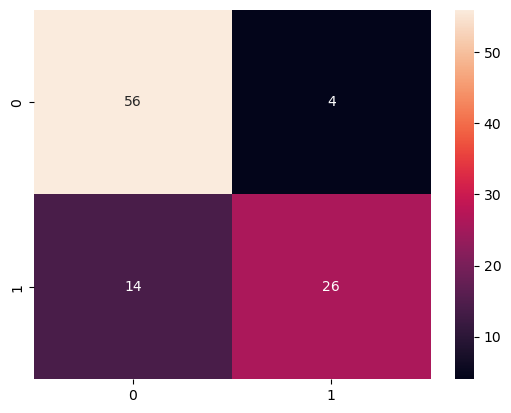

In [35]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)

import seaborn as sns
sns.heatmap(cf_matrix, annot=True)
plt.show()

**Observations**: Good scoring, despite class imbalances. Accuracy 80% and lowest recall is 69%.
    
    So let's try and see how the Active Learning compares to this performance. 

# ACTIVE LEARNING

### Tasks

1. fit the first model only on the **start_df** using **SVM** and evaluate accuracy, precision and recall on test_df
2. in each iteration, add 10 observations from **df** to your trainset (choose the observation using active learning approach) 
    - score all observations in df and take 10 where the model isn't sure what class it is. The probability of surviving will be around 50% 
3. refit the model and evaluate on **test_df** again.    
3. the goal is to converge to the optimal solution as fast as possible by choosing **right** observations in each iteration
4. plot the graphs for each eval metric, where on the axis x is iteration number, on y is the metric value for that model

# 1. fit the first model only on the start_df 
using SVM and evaluate accuracy, precision and recall on test_df

In [51]:
# train_df is the set of the entire dataset available for training

start_df = train_df.sample(n=100, random_state=394) # this is our first batch of labelled data

df = train_df[~train_df.PassengerId.isin(start_df.PassengerId.tolist())] # this is what remains

# use class balancing function to generate X_train, y_train
X_train, y_train = class_balancing(train_df, 'Survived');

0    489
1    302
Name: Survived, dtype: int64

We need 187 new 1 records to offset class imbalance.


0    489
1    489
Name: Survived, dtype: int64

**Note**: We no longer have access to the entire dataset used to generate features in the Passive learning stage.

So the pipeline will only fit across the available data which will definitely skew the results.

In [52]:
def model_generator(df):
    """
    Generates a new model based on the increasing training dataset
    """

    cat_transform = Pipeline([
                        ('impute_mode', SimpleImputer(strategy='most_frequent')),
                        ('onehot_encoder', OneHotEncoder(sparse_output=False))
                        ])

    bin_transform = Pipeline([
                        ('impute_mode', SimpleImputer(strategy='most_frequent')),
                        ('onehot_encoder', OneHotEncoder(drop='if_binary', sparse_output=False))])

#     num_transform = Pipeline([
#                         ('custom_imputer', CustomImputer(df)),
#                         ('scaling', StandardScaler())])
    num_transform = Pipeline([
                        ('custom_imputer', CustomImputer(train_df)),
                        ('power_transformer', PowerTransformer(method="box-cox", standardize=True))])
    preprocessing = ColumnTransformer([
                        ('cat_transform', cat_transform, ['Pclass', 'Embarked']),
                        ('bin_transform', bin_transform, ['Sex']),
                        ('num_transform', num_transform, ['Age', 'Pclass', 'Sex'])], # the 2 are required but will be dropped
                    remainder='passthrough')


    # creating the final pipeline
    model = Pipeline([
                        ('add_new_columns', ColumnGenerator(df)),
                        ('preprocessing', preprocessing), 
                        ('classifier', SVC(probability=True))
                          ])
    
    return model

In [53]:
model_1 = model_generator(start_df)

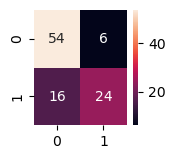

(0.78, 0.8, 0.6)

In [54]:
def scoring_test_df (model, X_train, y_train, 
                     X_test=X_test, y_test=y_test):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
#     print(classification_report(y_test, y_pred))
    
#     seaborn confusion matrix
    figure = plt.figure(figsize=(1.5,1.5))
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True)
    plt.show()
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = model.score(X_test, y_test)
    return accuracy, precision, recall


scoring_test_df(model_1, X_train, y_train)



# 2. in each iteration, add 10 observations from df

**score all observations in df**
and take 10 where the model isn't sure what class it is. The probability of surviving will be around 50%

In [55]:
def scoring_df(model, df=df):
    X_test_df = df.drop(columns='Survived')
    y_test_df = df['Survived']
    y_pred_df = model.predict(X_test_df)
    y_pred_probabilty = model.predict_proba(X_test_df)


    ## Creating a results table, listing the groundtruth, predictions, probabilities and proximity to 0.5 (guessing)

    results = y_test_df.to_frame()
    results['y_predictions'] = y_pred_df
    results['probabilities_0'] = y_pred_probabilty[:,0]
    results['probabilities_1'] = y_pred_probabilty[:,1]
    results.rename(columns={'Survived': 'y_true'}, inplace=True)


    filter = results['y_true'] != results['y_predictions']

    results['inverse_sorting'] = np.abs(results['probabilities_0'] - 0.5)


    scored_results = results[filter].sort_values('inverse_sorting')
    return scored_results[:10]

In [56]:
scored_results = scoring_df(model_1, df)

In [57]:
scored_results

y_true  y_predictions  probabilities_0  probabilities_1  inverse_sorting
192       1              0         0.500000         0.500000         0.000000
645       1              0         0.488761         0.511239         0.011239
430       1              0         0.481441         0.518559         0.018559
453       1              0         0.520927         0.479073         0.020927
607       1              0         0.472590         0.527410         0.027410
622       1              0         0.531214         0.468786         0.031214
660       1              0         0.465977         0.534023         0.034023
690       1              0         0.464577         0.535423         0.035423
709       1              0         0.546110         0.453890         0.046110
65        1              0         0.546110         0.453890         0.046110

* These are the most uncertain scores. They will be incorporated into the training data. And it will be re-trained.

* At this point, it is a good idea to functionalize our process.

In [58]:
scored_results.index

Int64Index([192, 645, 430, 453, 607, 622, 660, 690, 709, 65], dtype='int64')

In [59]:
def training_generator(start_df, scored_results, train_df=train_df):

    # updating the training index
    training_index = np.concatenate((start_df.index, scored_results.index))

    model_df = train_df.loc[training_index]
    X_train, y_train = class_balancing(model_df, 'Survived');

    # left over df
    df = train_df[~train_df.PassengerId.isin(model_df.PassengerId.tolist())]

    ## Remember train_df is thh entire dataset outside the test_df. 
    ## Start_df and df add up to train_df. With each iteration, df gets smaller and start_df gets larger

    return model_df, X_train, y_train, df

In [60]:
model_df, X_train, y_train, df = training_generator(start_df, scored_results, train_df=train_df)

0    64
1    46
Name: Survived, dtype: int64

We need 18 new 1 records to offset class imbalance.


0    64
1    64
Name: Survived, dtype: int64

In [ ]:
# initialization
start_df = train_df.sample(n=400, random_state=394)
X_train, y_train = class_balancing(start_df, 'Survived')

# left over df
df = train_df[~train_df.PassengerId.isin(start_df.PassengerId.tolist())]


num_iterations = 70

scores = [] # accuracy, precision, recall
models = []
for i in range(num_iterations):
    if i == 0:
        model_df = start_df  
    model = model_generator(model_df)
    models.append(model)
    score = scoring_test_df(model, X_train, y_train)
    scores.append(score) # accuracy, precision, recall
    scored_results = scoring_df(model, df)
    model_df, X_train, y_train, df = training_generator(model_df, scored_results, train_df=train_df)
    print(f"Iteration # {i}, scored {score}")
    

In [62]:
scores_df = pd.DataFrame(scores, columns=['Accuracy', 'Precision', 'Recall'])
scores_df

Accuracy  Precision  Recall
0       0.75   0.800000   0.500
1       0.75   0.777778   0.525
2       0.79   0.880000   0.550
3       0.80   0.833333   0.625
4       0.78   0.875000   0.525
..       ...        ...     ...
65      0.83   0.870968   0.675
66      0.83   0.870968   0.675
67      0.83   0.870968   0.675
68      0.84   0.875000   0.700
69      0.83   0.870968   0.675

[70 rows x 3 columns]

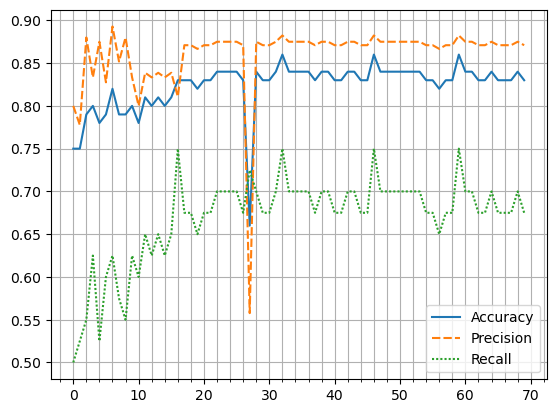

In [63]:
from matplotlib.ticker import MultipleLocator

ax = sns.lineplot(data=scores_df)
ax.xaxis.set_minor_locator(MultipleLocator(base=2))
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')


plt.grid()

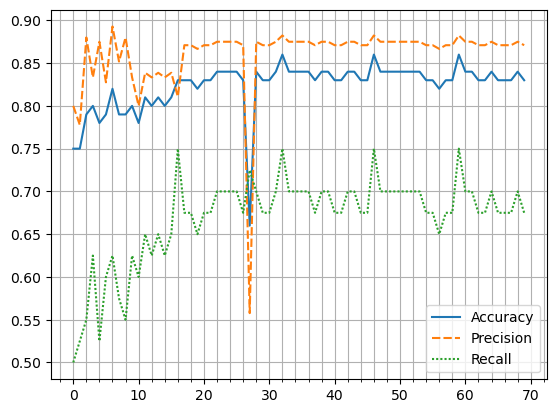

In [64]:
from matplotlib.ticker import MultipleLocator

ax = sns.lineplot(data=scores_df)
ax.xaxis.set_minor_locator(MultipleLocator(base=2))
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')


plt.grid()

## Observations 
The results flunctuated a bit the jumped up at the 46th mark, which approximates i.e. when the training_set was 560. Compare this to the original "Passive Training" that required a dataset of 791 records.

## Conclusions:

Active Learning is definitely an advantage when the source data is "expensive".

Even the human "cost" i.e. manually labelling the data can be mitigated to some extent with automation.

However, its advantage is strictly in situations where data is expensive. Not having a large dataset restricts opportunities in feature engineering, which can in turn affect the efficiency of the model. 

In [65]:
kaggle_test = pd.read_csv('test.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'

In [ ]:
model = models[-1]

In [ ]:
kaggle_test = kaggle_test.reindex(columns=X_train.columns)

In [ ]:
submission = pd.DataFrame(model.predict(kaggle_test)).rename(columns={0:'Survived'})
submission.index = kaggle_test['PassengerId']
submission

In [ ]:
submission.to_csv('kaggle_competition.csv', index=True)